<a href="https://colab.research.google.com/github/titantooth/Blog-graphql-graphcms-react-nextjs/blob/main/portfolio_return_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance pandas

In [2]:
import yfinance as yf
import pandas as pd

# Define the assets and their descriptions
tickers = {
    "SPY": "Equities (S&P 500)",            # US large-cap equities
    "DAX": "DAX germany",            # US large-cap equities
    "^FCHI": "CAC40",
    "IEF": "Fixed Income (US 7-10Y Bonds)", # Intermediate US Treasury Bonds
    #"GLD": "Gold",                          # Gold spot price proxy
    "EURUSD=X": "EUR/USD",                  # FX rate: euro to USD
    "JPY=X": "USD/JPY",                     # FX rate: dollar to yen
    "^VIX": "Volatility Index (VIX)"        # Volatility index (proxy for derivatives strategy)
}

# Download 5 years of monthly data
start_date = "2019-01-01"
end_date = "2024-12-31"
data = yf.download(list(tickers.keys()), start=start_date, end=end_date, interval="1mo")["Close"]

# Drop rows with missing values and rename columns
data.dropna(inplace=True)
data.rename(columns=tickers, inplace=True)

# Compute monthly returns
returns = data.pct_change().dropna()

# Display the first few rows
print(returns.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  7 of 7 completed


Ticker      DAX germany   EUR/USD  Fixed Income (US 7-10Y Bonds)   USD/JPY  \
Date                                                                         
2019-02-01    -0.003984 -0.009354                      -0.007341  0.017260   
2019-03-01     0.015600 -0.012929                       0.026743  0.000072   
2019-04-01     0.068374 -0.004262                      -0.005317  0.007279   
2019-05-01     0.002360 -0.004831                       0.030529 -0.020774   
2019-06-01    -0.025377  0.023340                       0.012219 -0.014722   

Ticker      Equities (S&P 500)     CAC40  Volatility Index (VIX)  
Date                                                              
2019-02-01            0.032416  0.049634               -0.108027  
2019-03-01            0.013636  0.020990               -0.072395  
2019-04-01            0.045437  0.044085               -0.043034  
2019-05-01           -0.063771 -0.067804                0.426067  
2019-06-01            0.064409  0.063626           

In [3]:
# Mean monthly return and volatility
mean_returns = returns.mean()
volatility = returns.std()
correlation_matrix = returns.corr()

# Display results
print("Expected Monthly Returns (%):")
print((mean_returns * 100).round(2))
print("\nVolatility (%):")
print((volatility * 100).round(2))
print("\nCorrelation Matrix:")
print(correlation_matrix.round(2))

Expected Monthly Returns (%):
Ticker
DAX germany                      0.70
EUR/USD                         -0.11
Fixed Income (US 7-10Y Bonds)    0.02
USD/JPY                          0.51
Equities (S&P 500)               1.13
CAC40                            0.84
Volatility Index (VIX)           4.08
dtype: float64

Volatility (%):
Ticker
DAX germany                       6.94
EUR/USD                           2.16
Fixed Income (US 7-10Y Bonds)     2.21
USD/JPY                           2.49
Equities (S&P 500)                5.49
CAC40                             5.77
Volatility Index (VIX)           30.43
dtype: float64

Correlation Matrix:
Ticker                         DAX germany  EUR/USD  \
Ticker                                                
DAX germany                           1.00     0.50   
EUR/USD                               0.50     1.00   
Fixed Income (US 7-10Y Bonds)         0.21     0.33   
USD/JPY                              -0.37    -0.62   
Equities (S&P 500) 

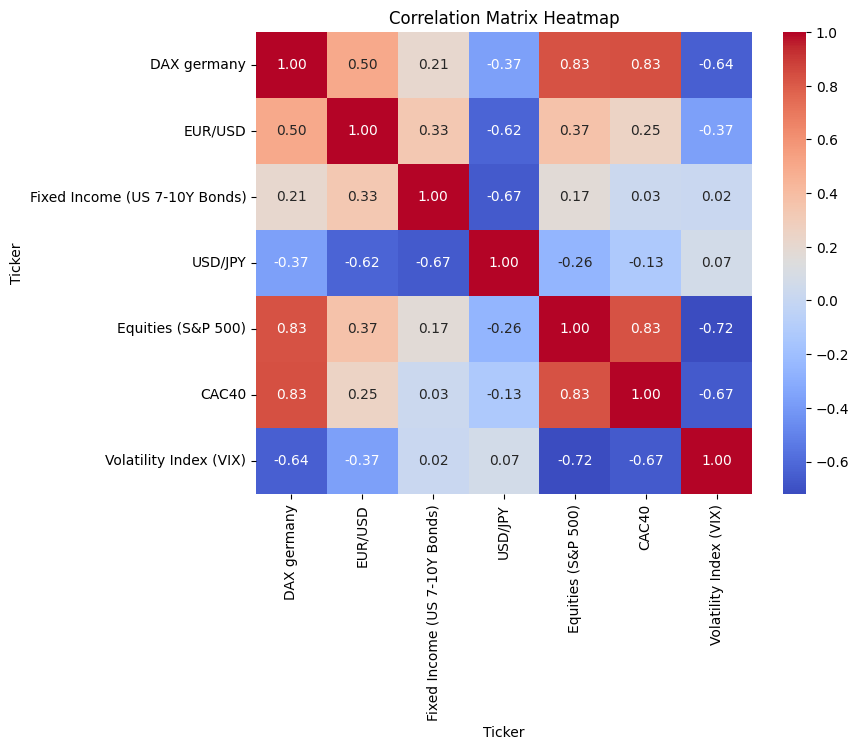

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

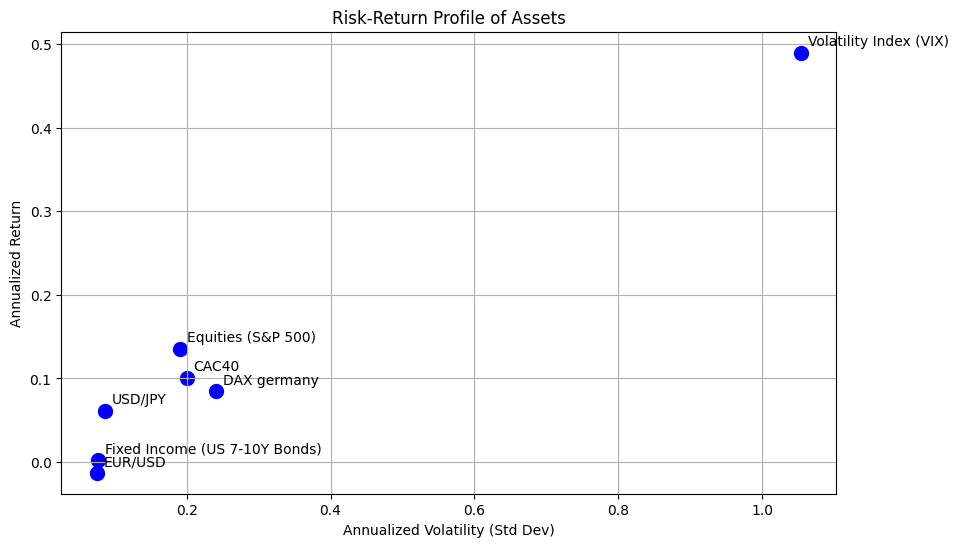

In [5]:
import matplotlib.pyplot as plt
import numpy as np


# Risk-return data
returns_annualized = mean_returns * 12
vol_annualized = returns.std() * np.sqrt(12)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(vol_annualized, returns_annualized, c='blue', s=100)

# Annotate points
for label, x, y in zip(returns.columns, vol_annualized, returns_annualized):
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(5, 5), ha='left')

plt.xlabel('Annualized Volatility (Std Dev)')
plt.ylabel('Annualized Return')
plt.title('Risk-Return Profile of Assets')
plt.grid(True)
plt.show()

In [6]:
import numpy as np
from scipy.optimize import minimize

# Convert to NumPy arrays
mean_returns_np = mean_returns.values
cov_matrix = returns.cov().values
num_assets = len(mean_returns_np)

# Objective: Minimize portfolio variance (for a target return)
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

# Constraint: weights must sum to 1
def weight_sum_constraint(weights):
    return np.sum(weights) - 1

# Bounds: No shorting → each weight in [0,1]
bounds = tuple((0, 1) for _ in range(num_assets))

# Initial guess: equal weights
init_guess = np.ones(num_assets) / num_assets

# Target return (optional) — could be mean of assets
target_return = mean_returns_np.mean()

# Constraint: expected return equals target
def return_constraint(weights):
    return weights @ mean_returns_np - target_return

# Combine constraints
constraints = (
    {"type": "eq", "fun": weight_sum_constraint},
    {"type": "eq", "fun": return_constraint}
)

# Optimization
opt_result = minimize(
    portfolio_variance,
    init_guess,
    args=(cov_matrix,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Extract optimal weights
opt_weights = opt_result.x
opt_portfolio = pd.Series(opt_weights, index=mean_returns.index)

# Display
print("Optimal Portfolio Weights (%):")
print((opt_portfolio * 100).round(2))

Optimal Portfolio Weights (%):
Ticker
DAX germany                       0.00
EUR/USD                           2.70
Fixed Income (US 7-10Y Bonds)     2.01
USD/JPY                          37.75
Equities (S&P 500)               34.44
CAC40                            15.32
Volatility Index (VIX)            7.78
dtype: float64


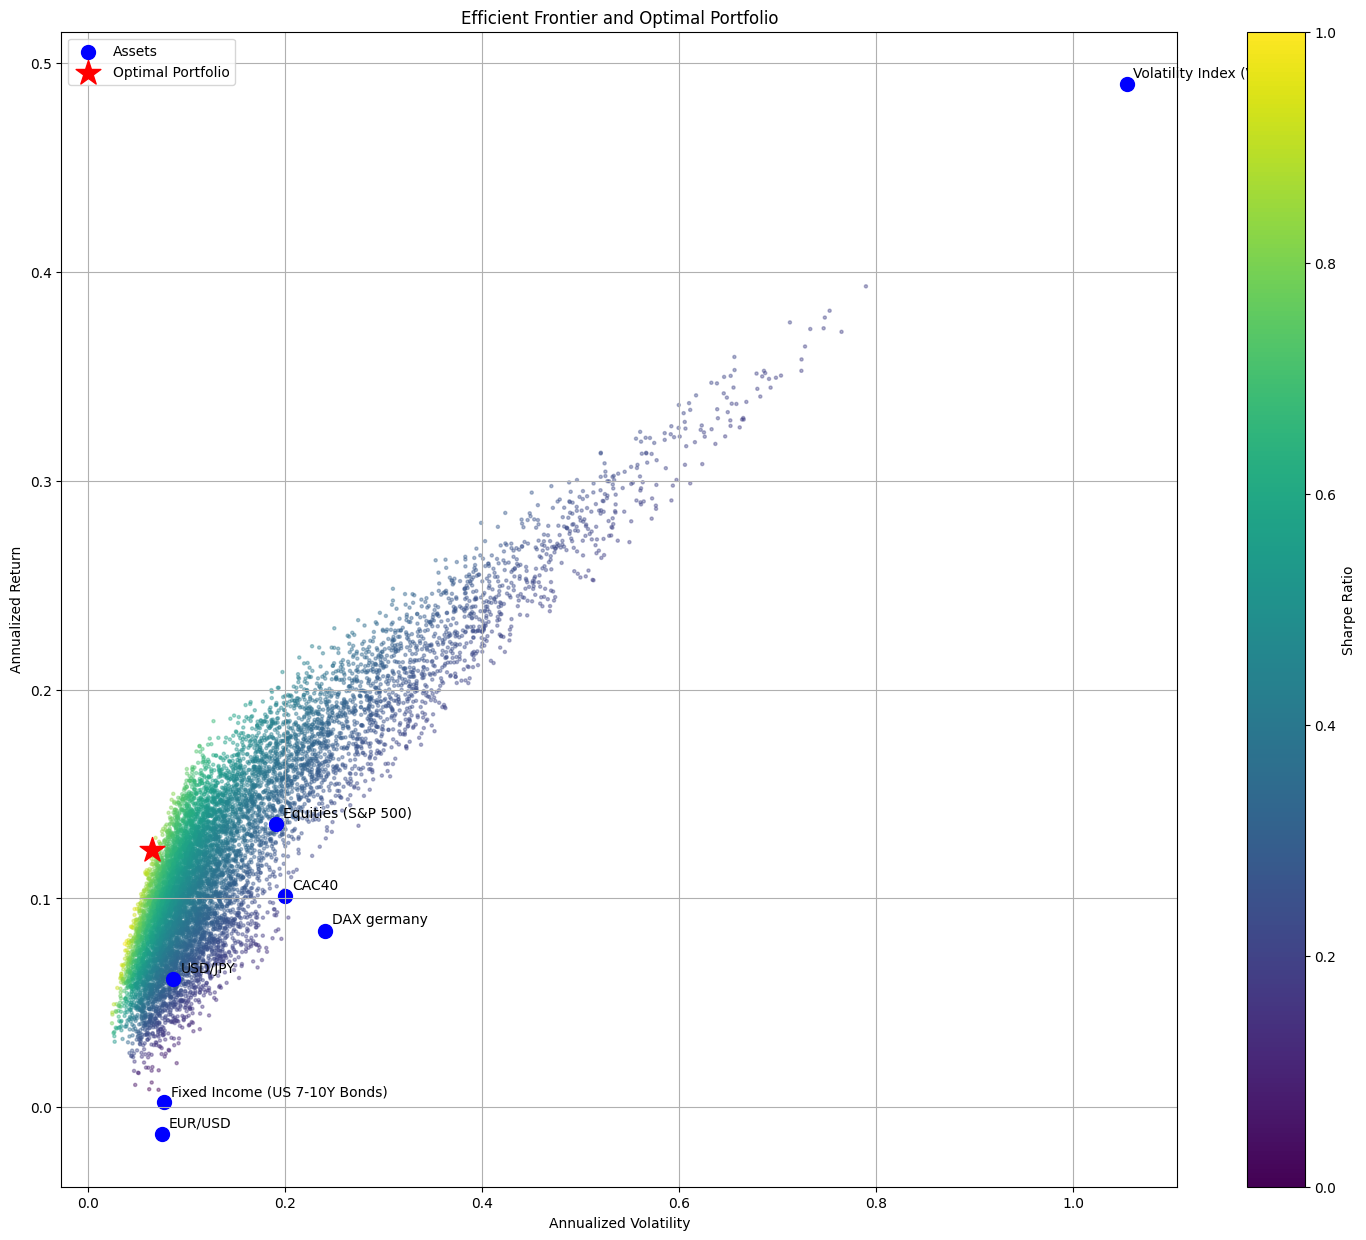

In [7]:
import matplotlib.pyplot as plt

# Annualized returns and volatility
annual_returns = mean_returns * 12
annual_volatility = returns.std() * np.sqrt(12)
cov_matrix_annual = returns.cov() * 12

# Simulate many portfolios to draw the efficient frontier
num_portfolios = 10_000
all_weights = np.random.dirichlet(np.ones(num_assets), size=num_portfolios)
portfolio_returns = all_weights @ annual_returns.values
portfolio_vols = np.sqrt(np.einsum('ij,jk,ik->i', all_weights, cov_matrix_annual, all_weights))

# Risk & return of the optimal portfolio
opt_return = opt_weights @ annual_returns.values
opt_vol = np.sqrt(opt_weights.T @ cov_matrix_annual @ opt_weights)

# Plot
plt.figure(figsize=(18, 15))
plt.scatter(portfolio_vols, portfolio_returns, c=portfolio_returns / portfolio_vols, cmap='viridis', alpha=0.4, s=5)
plt.scatter(annual_volatility, annual_returns, c='blue', s=100, label='Assets')

# Annotate assets
for label, x, y in zip(returns.columns, annual_volatility, annual_returns):
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(5,5), ha='left')

# Plot the optimal portfolio
plt.scatter(opt_vol, opt_return, c='red', s=350, marker='*', label='Optimal Portfolio')

# Labels
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.title('Efficient Frontier and Optimal Portfolio')
plt.colorbar(label='Sharpe Ratio')
plt.legend()
plt.grid(True)
plt.show()